In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
from matplotlib import pyplot as plt
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dfs = pickle.load( open( "dfs.data", "rb" ) )

In [ ]:
mx=0
for i in range(len(dfs)):
    if len(dfs[i])>mx:
        mx=i
print(mx)

In [3]:
a=dfs[1].iloc[:,:34]

In [4]:
t=list()
for i in a.columns:
    t.append(a[i].dropna())

In [5]:
x=list()
y=list()
columns=list()
for i in t:
    x.append(np.asarray(i.index))
    y.append(np.asarray(i))
    columns.append(i.name)

In [6]:
x_torch=list()
y_torch=list()
for i in range(len(x)):
    x_torch.append(torch.from_numpy(x[i]).type(torch.FloatTensor))
    y_torch.append(torch.from_numpy(y[i]).type(torch.FloatTensor))

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=len(x), rank=len(x)-1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [9]:
train_i_task=list()
for i in range(len(x)):
    train_i_task.append(torch.full_like(x_torch[i], dtype=torch.long, fill_value=i))

In [10]:
full_train_x = torch.cat(x_torch)
full_train_i = torch.cat(train_i_task)
full_train_y = torch.cat(y_torch)

In [11]:
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [12]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/500 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 108.707
Iter 2/500 - Loss: 61.102
Iter 3/500 - Loss: 42.775
Iter 4/500 - Loss: 32.829
Iter 5/500 - Loss: 26.636
Iter 6/500 - Loss: 22.679
Iter 7/500 - Loss: 19.889
Iter 8/500 - Loss: 17.944
Iter 9/500 - Loss: 16.495
Iter 10/500 - Loss: 15.379
Iter 11/500 - Loss: 14.526
Iter 12/500 - Loss: 13.863
Iter 13/500 - Loss: 13.273
Iter 14/500 - Loss: 12.707
Iter 15/500 - Loss: 12.244
Iter 16/500 - Loss: 11.837
Iter 17/500 - Loss: 11.380
Iter 18/500 - Loss: 10.958
Iter 19/500 - Loss: 10.651
Iter 20/500 - Loss: 10.207
Iter 21/500 - Loss: 9.945
Iter 22/500 - Loss: 9.578
Iter 23/500 - Loss: 9.359
Iter 24/500 - Loss: 9.077
Iter 25/500 - Loss: 8.848
Iter 26/500 - Loss: 8.683
Iter 27/500 - Loss: 8.520
Iter 28/500 - Loss: 8.366
Iter 29/500 - Loss: 8.164
Iter 30/500 - Loss: 8.061
Iter 31/500 - Loss: 7.912
Iter 32/500 - Loss: 7.855
Iter 33/500 - Loss: 7.752
Iter 34/500 - Loss: 7.615
Iter 35/500 - Loss: 7.564
Iter 36/500 - Loss: 7.516
Iter 37/500 - Loss: 7.432
Iter 38/500 - Loss: 7.309


In [13]:
model.eval()
likelihood.eval()
test_x = torch.linspace(0, len(a), len(a)+1)
test_i_task=list()
for i in range(len(x)):
    test_i_task.append(torch.full_like(test_x, dtype=torch.long, fill_value=i))

observed_pred=list()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(len(x)):
        observed_pred.append(likelihood(model(test_x, test_i_task[i])))

In [14]:
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

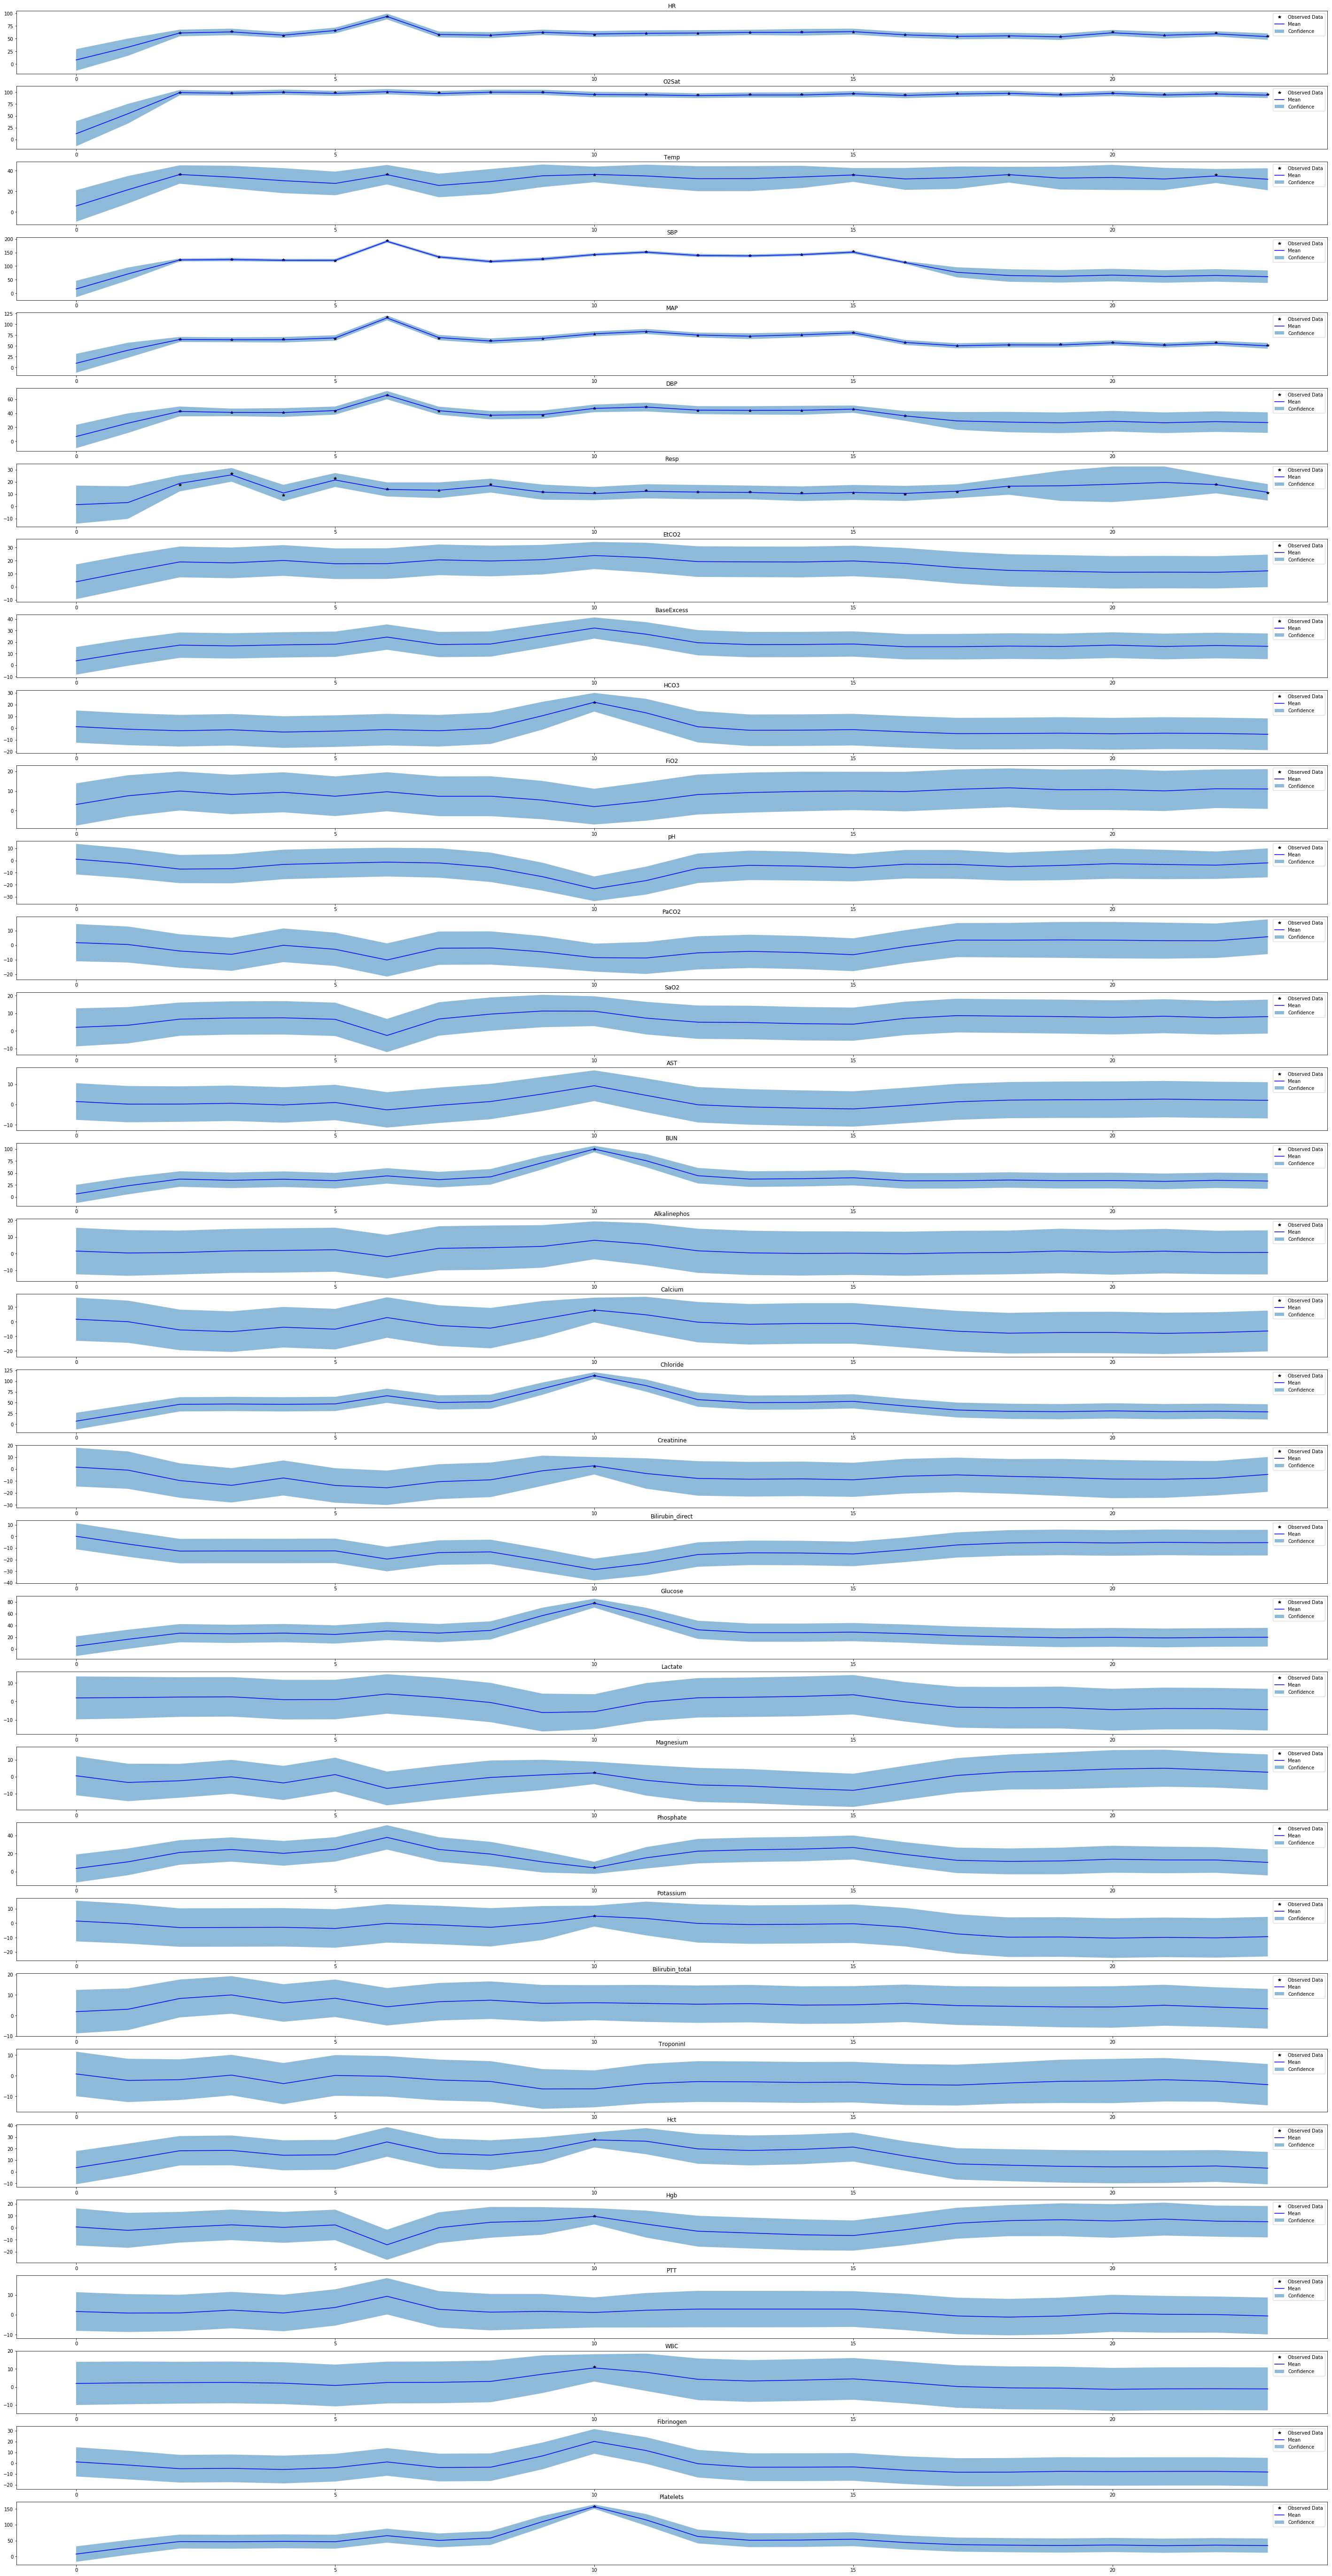

In [21]:
f = plt.figure(figsize=(50,100))
ax_plots=list()
for i in range(len(x)):
    ax_plots.append(plt.subplot(len(x),1,i+1))
for i in range(len(x)):
    ax_plot(ax_plots[i], y_torch[i], x_torch[i], observed_pred[i], columns[i])